In [5]:
import numpy as np
import matplotlib.pyplot as plt
import sys

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from rdkit import Chem, DataStructs
from sklearn.neighbors import KNeighborsRegressor

sys.path.append("..")
from data.data_accessors import tmprss2_to_pandas

In [6]:
# collect dataset
dataset = tmprss2_to_pandas()

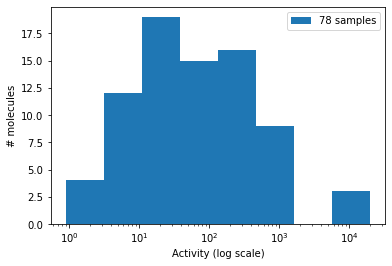

In [86]:
# visualize dataset
plt.figure()
hist, bins, _ = plt.hist(dataset.Activity, bins=8)
plt.clf()
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
plt.hist(dataset.Activity, bins=logbins, label=f"{len(dataset)} samples")
plt.xscale('log')
plt.xlabel('Activity (log scale)')
plt.ylabel('# molecules')
plt.title('distribution of ')
plt.show()

In [22]:
# calculate fingerprints
dataset['fingerprints'] = dataset.SMILES.apply(lambda s: Chem.RDKFingerprint(Chem.MolFromSmiles(s)))
# convert fingerprints to arrays
X = np.zeros([len(dataset), 2048])
for i in range(len(dataset)):
    DataStructs.ConvertToNumpyArray(dataset.fingerprints.iloc[i], X[i])


In [43]:
# set up data and labels for knn
y = dataset.Activity.values

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=3)
print(f"train_X.shape: {train_X.shape}")
print(f"train_y.shape: {train_y.shape}")
print(f"test_X.shape: {test_X.shape}")
print(f"test_y.shape: {test_y.shape}")

train_X.shape: (62, 2048)
train_y.shape: (62,)
test_X.shape: (16, 2048)
test_y.shape: (16,)


In [44]:
# define our tanimoto similarity function, to be used as distance metric in knn

def tanimoto_similarity(fp1, fp2):
    """from http://infochim.u-strasbg.fr/CS3_2014/Slides/CS3_2014_Willett.pdf"""
    c = np.sum((fp1 == fp2) & (fp1 == 1))  # bits set in common
    a = np.sum(fp1)  # bits set in fp1
    b = np.sum(fp2)  # bits set in fp2
    if (a + b - c) == 0:
        print(a, b, c)
    return c / (a + b - c)

In [45]:
# define our knn function
def run_knn(k, train_X, train_y, test_X, test_y):
    nbrs = KNeighborsRegressor(n_neighbors=k, algorithm='auto',
                               metric=tanimoto_similarity)
    nbrs.fit(train_X, train_y)
    return nbrs.predict(test_X)


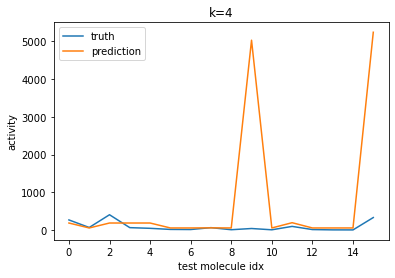

In [81]:
# show example knn predictions
def plot_knn_acc(k):
    pred_k2 = run_knn(k, train_X, train_y, test_X, test_y)
    plt.figure()
    plt.plot(test_y, label='truth')
    plt.plot(pred_k2, label='prediction')
    plt.xlabel('test molecule idx')
    plt.ylabel('activity')
    plt.legend()
    plt.title(f"k={k}")
    plt.show()
plot_knn_acc(k=4)

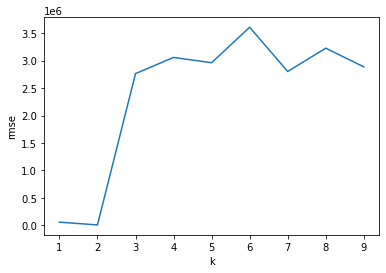

In [84]:
# show performance over various ks
rmse = []
ks = np.arange(1, 10)
for k in ks:
    pred = run_knn(k, train_X, train_y, test_X, test_y)
    rmse.append(mean_squared_error(test_y, pred))

plt.plot(ks, rmse)
plt.xlabel("k")
plt.ylabel("rmse")
plt.show()

best k: 2


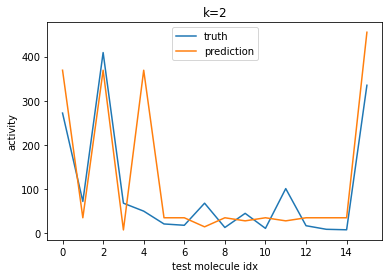

In [83]:
# show optimized knn predictions
best_k = np.argmin(rmse)+1
print(f"best k: {best_k}")
plot_knn_acc(best_k)